# TEDx Transcript Scraper


This scraper downloads the transcript of the talks present in the details.json (nothing but the details.csv file converted to json)

The details dataset is composed by the following attributes:
- id
- slug
- interalId
- description
- duration
- socialDescription
- presenterDisplayName
- publishedAt


The transcripts dataset is composed by the following attributes:
- id 
- internalId
- time
- text


The notebook is organized with the following sections:

- Setup of the env (install libraries, set up variables and credentials, ...)
- Download of the index (with Selenium and Chrome Browser libraries + API)
- Store the data on CSV files

### Setup of the env

Install and import of python libraries

In [2]:
!pip install chromedriver-py
!pip install selenium

In [3]:
import sys
import logging
from selenium.webdriver.remote.remote_connection import LOGGER
LOGGER.setLevel(logging.WARNING)
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from tqdm.notebook import tqdm
import pandas as pd
import time
import hashlib
import json
import pprint
from chromedriver_py import binary_path
import requests


Set the following variables to download data:

- max_page: max number of pages to loop (set to -1 to download all the pages)
- sleep_time: to be polite with TEDx (number of seconds between different request)




In [4]:
max_page = 300
sleep_time = 1
log = False

In [5]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument("window-size=1900,800")
chrome_options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36")

In [6]:
def get_browser():
    service = Service(executable_path=binary_path)
    wd = webdriver.Chrome(service=service, options=chrome_options)
    return wd

browser = get_browser()

def talks_page():
    url = 'https://www.ted.com/talks?sort=newest'
    print(f'Navigate to {url}')
    browser.get(url)
    time.sleep(sleep_time * 4)
    try:
      cookie_btn = browser.find_elements(By.ID, 'onetrust-accept-btn-handler')
      cookie_btn.click()
    except:
      pass
    time.sleep(sleep_time)

talks_page()

Navigate to https://www.ted.com/talks?sort=newest


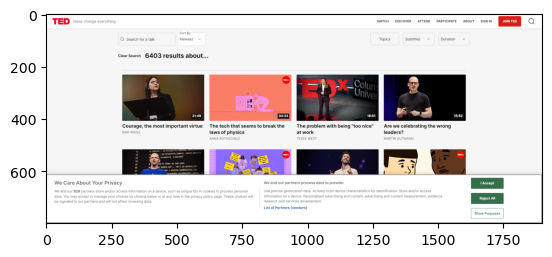

In [7]:
browser.save_screenshot('screenshot.png')

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/Users/utente/Downloads/screenshot.png') 
imgplot = plt.imshow(img)
plt.show()

# Get TEDx transcripts


First of all we will take all the data using API. We will simulate the navigation in the web site and we will download the data for all the TED Talks.

In [8]:
# Retrieve JSON data from the file
with open('/Users/utente/Downloads/Dataset-20240507T144551Z-001/Dataset/details.json') as file:
    final_list = json.load(file)
    
translations = []
ready = []

In [9]:
for video in tqdm(final_list):
    slug = video["slug"]
    interalId = video["interalId"]
    if slug not in ready:
        query = f"""
        {{
            translation(videoId: "{interalId}", 
            language:"en") 
            {{ 
                paragraphs {{
                    cues {{
                        time
                        text
                    }}
                }}
            }}
        }}
        """
        payload = [{
            "operationName": None,
            "variables": {},
            "query": query}]
        
        r = requests.post('https://www.ted.com/graphql',
                        headers={'Content-type': 'application/json; charset=UTF-8',
                                    "User-Agent": "curl/7.64.1"},
                        json=payload)
        
        if len(r.json()[0]) > 0 and r.json()[0]["data"] is not None and r.json()[0]["data"]["translation"] is not None:
            if len(r.json()[0]["data"]["translation"]["paragraphs"]) > 0:
                for paragraph in r.json()[0]["data"]["translation"]["paragraphs"]:
                    for cue in paragraph["cues"]:
                        translations.append({
                            "id": video["id"],
                            "internalId": video["interalId"],
                            "time": cue["time"],
                            "text": cue["text"]})
    ready.append(slug)

  0%|          | 0/6363 [00:00<?, ?it/s]

In [13]:
translations[100]

{'id': 527254,
 'internalId': 128758,
 'time': 88756,
 'text': 'which will enable me to start the paddle.'}

## Store the data to CSV file



In [14]:
df = pd.DataFrame.from_dict(translations)
df = df.to_csv('transcripts.csv', index=False)